# Test 02. Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- __LIMIT_BAL__: размер кредитного лимита (в том числе и на семью клиента)
- __SEX__: пол клиента (1 = мужской, 2 = женский )
- __EDUCATION__: образование(0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных).
- __MARRIAGE__: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- __AGE__: возраст в годах
- __PAY_0 - PAY_6__ : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- __BILL_AMT1 - BILL_AMT6__: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- __PAY_AMT1 - PAY_AMT6__: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- __default__ - индикатор невозврата денежных средств

## Задание
1. __Размер кредитного лимита (LIMIT_BAL):__ В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?
2. __Пол (SEX):__ Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия).
3. __Образование (EDUCATION):__ Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? наоборт, не отдаст долг?
4. __Семейное положение (MARRIAGE):__ Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.
5. __Возраст (AGE):__ Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

### Review criteria
1. Выполнение каждого пункта задания должно начинаться с графика с данными, которые вы собираетесь анализировать. Еще лучше, если вы разложите графики анализируемого фактора по переменной (default), на которую хотите изучить влияние этого фактора, и проинтерпретируете отличия в полученных распределениях.
2. При использовании статистических критериев необходимо убедиться в том, что условия их применимости выполняются. Например, если вы видите, что данные бинарные, то не нужно применять критерий Стьюдента.
3. При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость.
4. Выполненное задание необходимо представить в ipython-ноутбука.

## Решение

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

import itertools 
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import binom_test
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from scipy.stats.contingency import expected_freq

from seaborn import heatmap

from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline

matplotlib.style.use('ggplot')

permutations = 22000
boostrap_size = 20000

### Загружаем данные

In [2]:
df = pd.read_csv("credit_card_default_analysis.csv", sep=",", header=0)
print("Data shape: (rows:{}, cols:{})".format(df.shape[0], df.shape[1]))
df.head()

Data shape: (rows:30000, cols:25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
print("Data have Empty values: {}".format(df.isnull().values.any()))

Data have Empty values: False


### Подготавливаем необходимые функции

__Функции для использования Bootstrap__

In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

__Функции для использования перестановочного критерия__

In [5]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() for i in indices]
    
    t_stat = np.mean(sample1) - np.mean(sample2)
    
    return distr, t_stat

def permutation_test(zero_distr, t_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

__Доверительный интервал для разности долей (независимые выборки)__

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [6]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = norm.ppf(1 - alpha / 2.0)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary  = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    
    return (left_boundary, right_boundary)

__Z-критерий для разности долей (независимые выборки)__

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [7]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1))  / n1
    p2 = float(sum(sample2))  / n2 
    P  = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - norm.cdf(z_stat)

__Функции для вычисления коэффициента корреляции V Краммера, а также дост. уровня значимости__

In [8]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    (chi2, p, dof, ex) = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1))), p

def cramers_stat(confusion_matrix):
    (chi2, p, dof, ex) = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1))), p

### Часть 00. __Распределение вернувших кредит против не вернувших__

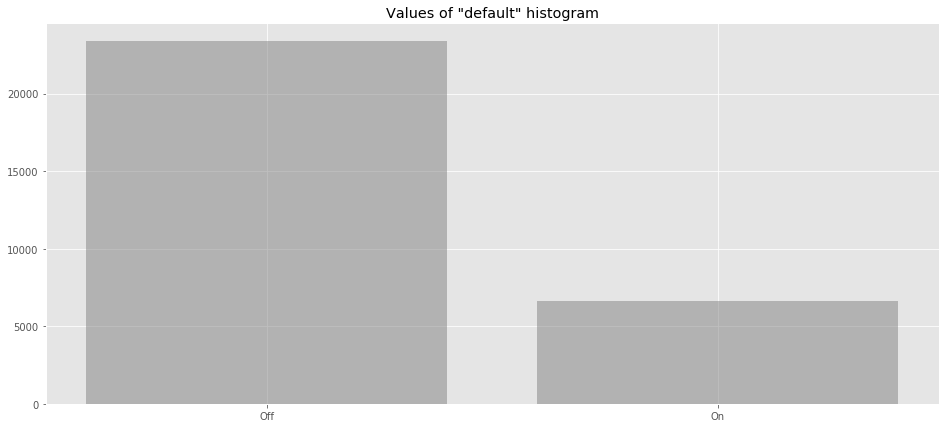

In [9]:
#Строим гистограммы количества вернувших кредит и не вернувших кредит
unique, counts = np.unique(df.default, return_counts=True)

def_dic = {0: "Off", 1 :"On"}

unique = [def_dic[idx] for idx in unique]

y_pos = np.arange(len(unique))

plt.figure(figsize=(16, 7))

plt.bar(y_pos, counts, color = 'grey', align='center', alpha=0.5)
plt.title("Values of \"default\" histogram")
plt.xticks(y_pos, unique)
plt.show()

Как видно на гистограмме, количество вернувших кредит в представленной выборке превышает число тех, кто не вернул кредит. Далее проверим, как это сказывается на работе банка, и как влияют на это состояние различные аттрибуты заемщика.

In [10]:
observed_frequences = np.bincount(df.default.values)
observed_proportion = float(observed_frequences[1]) / float(df.default.values.shape[0])

conf_int  = proportion_confint(observed_frequences[1],  df.default.values.shape[0], method = 'wilson')

print "Default proportion: {:1.4f} -> [{:1.4f}, {:1.4f}]".format(observed_proportion,  conf_int[0], conf_int[1])

Default proportion: 0.2212 -> [0.2165, 0.2259]


In [11]:
del unique, counts
del def_dic, y_pos
del observed_frequences
del observed_proportion
del conf_int

### Часть 01. __Размер кредитного лимита (LIMIT_BAL)__

В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте две гипотезы: 

1. О равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки
2. О равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Значимы ли полученные результаты с практической точки зрения ?

In [12]:
#Полготавливаем выборки
limits_def_on  = df[df.default == 1].LIMIT_BAL.values
limits_def_off = df[df.default != 1].LIMIT_BAL.values

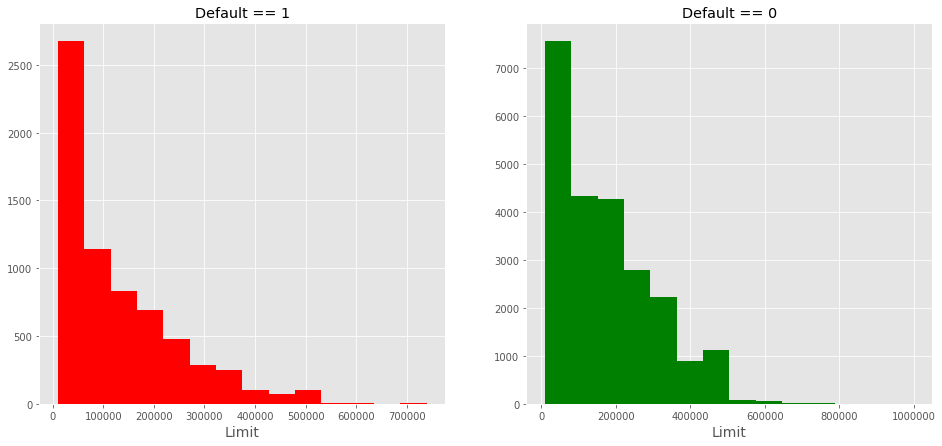

In [13]:
#Строим гистограммы по выборкам, чтобы их наглядно оценить
plt.figure(figsize=(16, 7))
plt.subplot(121)
plt.hist(limits_def_on, bins=14, color = 'r')
plt.xlabel('Limit', fontsize=14)
plt.title("Default == 1")

plt.subplot(122)
plt.hist(limits_def_off, bins=14, color = 'g')
plt.xlabel('Limit', fontsize=14)
plt.title("Default == 0")
plt.show()

Глядя на две представленные гистограммы, можно визуально определить, что медианные значения скорее всего разные. Ниже это и проверим.

#### a) Интервальная оценка медиан:

Выборки являются независимыми. Для оценки медиан будем использовать метод Bootstrap.

In [14]:
%%time
#Интервальная оценка медиан
np.random.seed(0)

medians_def_on  = map(np.median, get_bootstrap_samples(limits_def_on,  boostrap_size))
medians_def_off = map(np.median, get_bootstrap_samples(limits_def_off, boostrap_size))

CPU times: user 13.4 s, sys: 960 ms, total: 14.3 s
Wall time: 14.3 s


##### Точечные оценки медиан и их интервальные оценки в каждой выборке

In [15]:
conf_on  = zconfint(medians_def_on)
conf_off = zconfint(medians_def_off)

print "95% confidence interval and median:"
print "Default == 1: {:10.2f} -> [{:4.2f}, {:4.2f}]".format(np.mean(medians_def_on), conf_on[0], conf_on[1])
print "Default == 0: {:10.2f} -> [{:4.2f}, {:4.2f}]".format(np.mean(medians_def_off), conf_off[0], conf_off[1])

95% confidence interval and median:
Default == 1:   89716.00 -> [89685.50, 89746.50]
Default == 0:  150035.25 -> [150027.05, 150043.45]


##### Доверительный интервал для разности медиан (независимые выборки)

In [16]:
print "Difference between medians:", np.median(limits_def_off) - np.median(limits_def_on)
delta_medians = map(lambda x: x[0] - x[1], zip(medians_def_off, medians_def_on))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_medians, 0.05)
del delta_medians

Difference between medians: 60000.0
95% confidence interval for the difference between medians [ 60000.  70000.]


#### б) Проверка статистическим критерием равенство средних:

О равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

In [17]:
#Для начала получим точечную оценку среднего, а также интервальную оценку для каждой выборки
conf_on = zconfint(limits_def_on)
conf_off = zconfint(limits_def_off)

print "95% confidence interval and mean:"
print "Default == 1: {:10.2f} -> [{:10.2f}, {:10.2f}]".format(limits_def_on.mean(), conf_on[0], conf_on[1])
print "Default == 0: {:10.2f} -> [{:10.2f}, {:10.2f}]".format(limits_def_off.mean(), conf_off[0], conf_off[1])

del conf_on
del conf_off

95% confidence interval and mean:
Default == 1:  130109.66 -> [ 127333.65,  132885.66]
Default == 0:  178099.73 -> [ 176411.91,  179787.54]


##### Проверим гипотезу о равенстве распределений с помощью перестановочного критерия

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

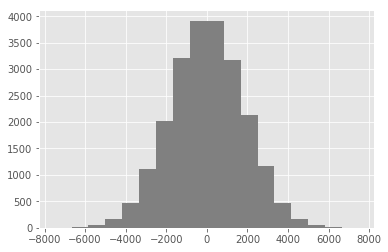

CPU times: user 1min 16s, sys: 6.26 s, total: 1min 23s
Wall time: 1min 38s


In [18]:
%%time
perm, t_stat = permutation_zero_dist_ind(limits_def_off, limits_def_on, max_combinations = permutations)

plt.hist(perm, bins=18, range=(-7500, 7500), color='gray')
plt.show()

In [19]:
print "p-value: %f" % permutation_test(perm, t_stat)

p-value: 0.000045


In [20]:
del limits_def_on
del limits_def_off

del medians_def_on
del medians_def_off

del perm

### <font color="green">Выводы 01: Анализ размера кредитного лимита (LIMIT_BAL)</font>

__Проверка гипотезы о равенстве распределений:__

__1. Интервальная оценка равенства медианных значений кредитного лимита:__
- Интервальная оценка медиан дает два непересекающихся интервала. Причем, интервал для медианы кредитного лимита тех, кто вернул кредит, лежит сильно правее интервала для медианного значения кредитного лимита у тех, кто его не вернул.
- Интервальные оценка разности двух медиан не содержит 0.

__2. Применение непараметрического критерия проверки равенства средних значений кредитного лимита.__

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

- Вычисленные достигаемый уровень значимости $p \ll 0.05$, следовательно, отвергаем $H_0$ о том, что средние значения равны.

__3. Общий вывод:__
- Распределения получаются разные, следовательно, природа событий, порождающих эти две выборки разнаяю
- С практической точки зрения результат говорит о том, что банк не страдает от невозвратных кредитов, находясь при этом в плюсе, т.к. кредитный лимит у людей, кто не вернул, значительно ниже.



### Часть 02.  __Пол (SEX)__

Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия) 

In [21]:
#Подготавливаем выборки
sex_def_on  = df[df.default == 1].SEX.values - 1
sex_def_off = df[df.default == 0].SEX.values - 1

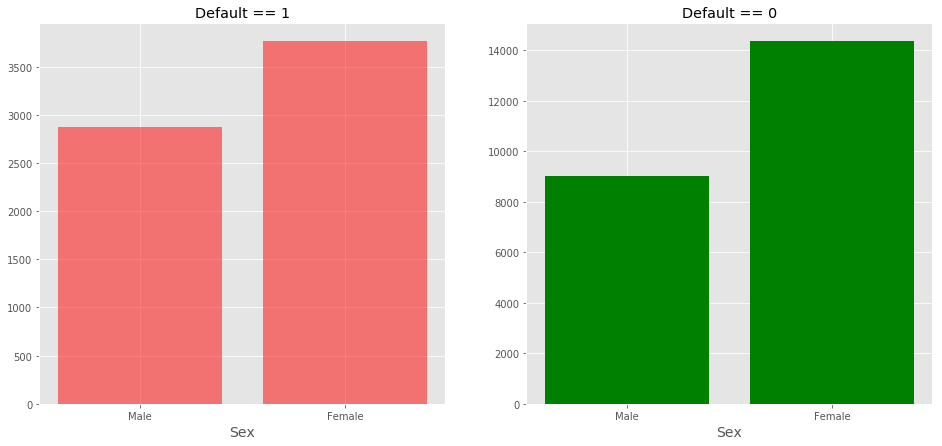

In [22]:
#Строим гистограммы значений, чтобы попробовать наглядно оценить различия
unique1, counts1 = np.unique(sex_def_on, return_counts=True)
unique2, counts2 = np.unique(sex_def_off, return_counts=True)

sex_dic = {0: "Male", 1 :"Female"}

unique1 = [sex_dic[idx] for idx in unique1]
unique2 = [sex_dic[idx] for idx in unique2]

y_pos1 = np.arange(len(unique1))
y_pos2 = np.arange(len(unique2))

plt.figure(figsize=(16, 7))
plt.subplot(121)

plt.bar(y_pos1, counts1, color = 'r', align='center', alpha=0.5)
plt.xlabel('Sex', fontsize=14)
plt.title("Default == 1")
plt.xticks(y_pos1, unique1)

plt.subplot(122)
plt.bar(y_pos2, counts2, color = 'g')
plt.xlabel('Sex', fontsize=14)
plt.title("Default == 0")
plt.xticks(y_pos2, unique2)
plt.show()

#### a) Интервальная оценка:

Выборки являются независимыми и бинарными. Присутствуют всего два значения: мужчина, женщина. Следовательно, можно использовать оценку доверительных интервалов для разности долей.

##### Точечные оценки долей и их интервальные оценки в каждой выборке

In [23]:
print "Female ratio (Default == 1): {}/{} ".format(sex_def_on.sum(),  sex_def_on.shape[0])
print "Female ratio (Default == 0): {}/{} ".format(sex_def_off.sum(), sex_def_off.shape[0])

conf_on  = proportion_confint(sex_def_on.sum(),  sex_def_on.shape[0],  method = 'wilson')
conf_off = proportion_confint(sex_def_off.sum(), sex_def_off.shape[0], method = 'wilson')

print "\n95% confidence interval:"
print 'Female (Default == 1): {:1.4f} -> [{:1.4f}, {:1.4f}]'.format(sex_def_on.mean(), conf_on[0], conf_on[1])
print 'Female (Default == 0): {:1.4f} -> [{:1.4f}, {:1.4f}]'.format(sex_def_off.mean(), conf_off[0], conf_off[1])

Female ratio (Default == 1): 3763/6636 
Female ratio (Default == 0): 14349/23364 

95% confidence interval:
Female (Default == 1): 0.5671 -> [0.5551, 0.5789]
Female (Default == 0): 0.6141 -> [0.6079, 0.6204]


Интервалы не пересекаются. Это уже хорошо.

#### Доверительный интервал для разности долей (независимые выборки)

In [24]:
print "\nDifference (def=0 - def=1): {:4.4f}".format(sex_def_off.mean() - sex_def_on.mean())

print "95%% confidence interval for a diff: [%f, %f]" % proportions_diff_confint_ind(sex_def_off, sex_def_on)


Difference (def=0 - def=1): 0.0471
95% confidence interval for a diff: [0.033635, 0.060548]


Видим, что интервалы опять же не пересекаются. Вроде как, женщины чаще возвращают кредит, чем мужчины. Причем возвращающих кредит женщин больше на $4.7\%$, чем женщин, не возращающих кредит. Проверим это далее с помощью статистического критерия.

#### б) Проверка статистическим критерием:

Выборки являются независимыми с неизвестной дисперсией. Следовательно, необходимо использовать Z-критерий для разности долей.

##### Z-критерий для разности долей (независимые выборки). Проверяем следующие гипотезы:

$H_0:$ Доля женщин в каждой выборке одинаковая

$H_1:$ Доля женщин в выборке людей, вернувших кредит, больше

In [25]:
z = proportions_diff_z_stat_ind(sex_def_off, sex_def_on)
print "p-value: {}".format(proportions_diff_z_test(z, "less"))

p-value: 0.999999999998


In [26]:
del sex_def_on
del sex_def_off
del unique1, counts1
del unique2, counts2
del sex_dic
del y_pos1, y_pos2
del conf_on
del conf_off

### <font color="green">Выводы 02: __Пол (SEX)__</font>

- ___Гендерный состав___ в группах людей, вернуших кредит и не вернувших кредит, ___разный___
- ___Женщины возвращают___ кредит ___чаще___, чем мужчины. 
- Количество ___женщин, вернувших кредит__ в среднем __на__ $4.7\%$ $(95\%$ доверительный интервал — $[3.36\%, 6.05\%]$) ___больше, чем женщин, не вернувших кредит___

### Часть 03.  __Образование (EDUCATION)__

Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг.

Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости?

Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [55]:
education_def_on  = df[df.default == 1].EDUCATION
education_def_off = df[df.default == 0].EDUCATION

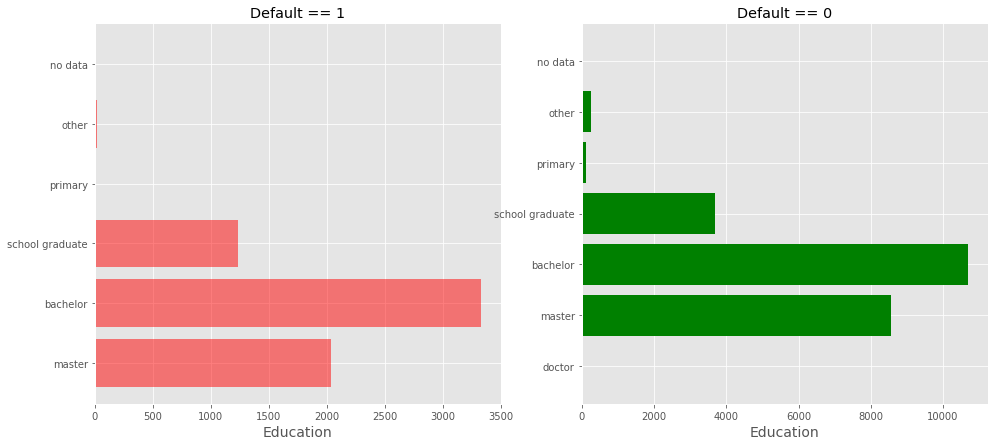

In [56]:
unique1, counts1 = np.unique(education_def_on,  return_counts=True)
unique2, counts2 = np.unique(education_def_off, return_counts=True)

edu_dic = {0: "doctor", 1 :"master", 2: "bachelor", 3: "school graduate", 4: "primary", 5: "other", 6: "no data"}

unique1 = [edu_dic[idx] for idx in unique1]
unique2 = [edu_dic[idx] for idx in unique2]

y_pos1 = np.arange(len(unique1))
y_pos2 = np.arange(len(unique2))

plt.figure(figsize=(16, 7))
plt.subplot(121)

plt.barh(y_pos1, counts1, color = 'r', align='center', alpha=0.5)
plt.xlabel('Education', fontsize=14)
plt.title("Default == 1")
plt.yticks(y_pos1, unique1)

plt.subplot(122)
plt.barh(y_pos2, counts2, color = 'g')
plt.xlabel('Education', fontsize=14)
plt.title("Default == 0")
plt.yticks(y_pos2, unique2)
plt.show()

#### Проверяем корреляцию между двумя категориальными величинами, используя коэффициент V Краммера

##### Проверяем следующие гипотезы:

$H_0:$ EDUCATION и default - независимы, то есть $\phi_c(X_1^n, X_2^N) = 0$

$H_1:$ EDUCATION влияет на default, то есть $\phi_c(X_1^n, X_2^N) \neq 0$

In [57]:
confusion_matrix = pd.crosstab(df['default'], df['EDUCATION']).as_matrix()

print "Cramers Vcorr=%f, p=%2.8f" % cramers_corrected_stat(confusion_matrix)
print "Cramers Vorig=%f, p=%2.8f" % cramers_stat(confusion_matrix)

Cramers Vcorr=0.073760, p=0.00000000
Cramers Vorig=0.073760, p=0.00000000


После применения вычисления коэффициента корреляции V Краммера и достигаемого уровня значимости, мы видим, то гипотезу $H_0$ можно смело отвергнуть. 

In [72]:
#Получаем матрицу сопряженности с разностью между наблюдаемым и ожидаемым количеством человек
ex_freq = expected_freq(confusion_matrix)
conjugacy_matrix = confusion_matrix - ex_freq
#Нормируем матрицу
conjugacy_matrix_norm = conjugacy_matrix / ex_freq#confusion_matrix.sum(axis=0)

In [73]:
confusion_df = pd.DataFrame(data=confusion_matrix, columns=unique2, index=["def=0", "def=1"])
confusion_df

,doctor,master,bachelor,school graduate,primary,other,no data
def=0,14,8549,10700,3680,116,262,43
def=1,0,2036,3330,1237,7,18,8


In [74]:
ex_freq_df = pd.DataFrame(data=ex_freq, columns=unique2, index=["def=0", "def=1"])
ex_freq_df

,doctor,master,bachelor,school graduate,primary,other,no data
def=0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
def=1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


In [75]:
conjugacy_df = pd.DataFrame(data=conjugacy_matrix_norm, columns=unique2, index=["def=0", "def=1"])
conjugacy_df

,doctor,master,bachelor,school graduate,primary,other,no data
def=0,0.284027,0.037047,-0.020735,-0.039004,0.210952,0.201482,0.082611
def=1,-1.000000,-0.130436,0.073004,0.137324,-0.742719,-0.709377,-0.290856


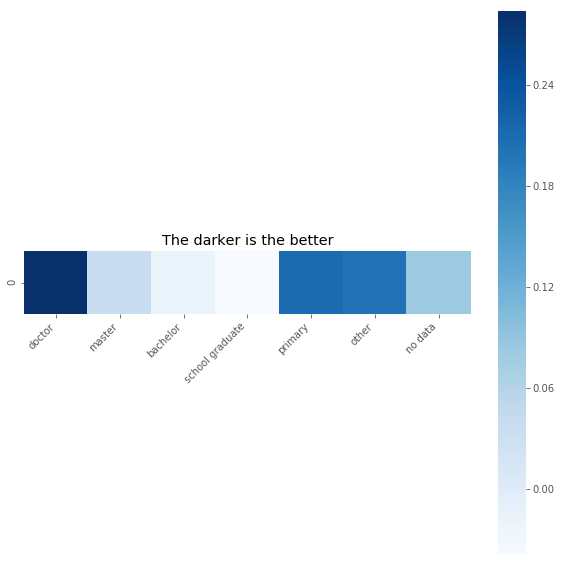

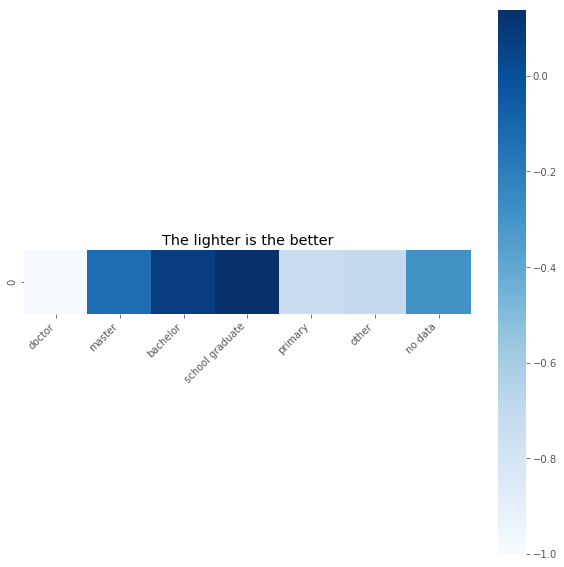

In [80]:
heatmap_matrix = conjugacy_matrix_norm
plt.figure(figsize=(10, 10))
ax = heatmap([heatmap_matrix[0]], square=True, cmap="Blues")
ax.set_xticklabels(unique2, rotation=45, ha='right', minor=False)
plt.title("The darker is the better")
plt.show()

heatmap_matrix = conjugacy_matrix_norm
plt.figure(figsize=(10, 10))
ax = heatmap([heatmap_matrix[1]], square=True, cmap="Blues")
ax.set_xticklabels(unique2, rotation=45, ha='right', minor=False)
plt.title("The lighter is the better")
plt.show()

Глядя на представленную карту, можно сказать, что больше всего проблем с возратом кредитов у людей, имеющих scholl graduate и bachelor. Менее всего проблем у докторов наук.

### <font color="green">Выводы 03: __Образование (EDUCATION)__ </font>
- Не видная на первый вгляд корреляция между образованием и значением default все же есть. 
- Коээфициент корреляции V Краммера отличен от 0 и составляет 0.074 - слабая корреляция
- Люди, имеющие school graduate и bachelor, хуже всего возращают долг
- Лица со степенью доктора наук лучше остальных отдают долг

In [35]:
del education_def_on
del education_def_off

del unique1, counts1
del unique2, counts2
del y_pos1, y_pos2

del edu_dic

del confusion_matrix
del ex_freq
del conjugacy_matrix
del conjugacy_matrix_norm

del confusion_df, ex_freq_df, conjugacy_df, heatmap_matrix, ax

### Часть 04.  __Семейное положение (MARRIAGE)__

Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [36]:
mariage_def_on  = df[df.default == 1].MARRIAGE
mariage_def_off = df[df.default == 0].MARRIAGE

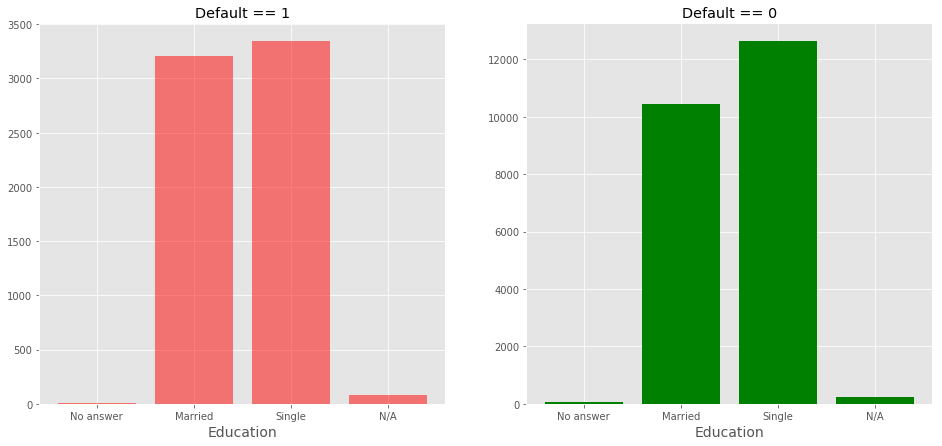

In [37]:
unique1, counts1 = np.unique(mariage_def_on,  return_counts=True)
unique2, counts2 = np.unique(mariage_def_off, return_counts=True)

mariage_dic = {0: "No answer", 1 :"Married", 2: "Single", 3: "N/A"}

unique1 = [mariage_dic[idx] for idx in unique1]
unique2 = [mariage_dic[idx] for idx in unique2]

y_pos1 = np.arange(len(unique1))
y_pos2 = np.arange(len(unique2))

plt.figure(figsize=(16, 7))
plt.subplot(121)

plt.bar(y_pos1, counts1, color = 'r', align='center', alpha=0.5)
plt.xlabel('Education', fontsize=14)
plt.title("Default == 1")
plt.xticks(y_pos1, unique1)

plt.subplot(122)
plt.bar(y_pos2, counts2, color = 'g')
plt.xlabel('Education', fontsize=14)
plt.title("Default == 0")
plt.xticks(y_pos2, unique2)
plt.show()

#### Считаем корреляцию Краммера, так как семейный статус и default можно считать категориальными признаками
##### Проверяем следующие гипотезы:

$H_0:$ MARRIAGE и default - независимы, то есть $\phi_c(X_1^n, X_2^N) = 0$

$H_1:$ MARRIAGE влияет на default, то есть $\phi_c(X_1^n, X_2^N) \neq 0$

In [38]:
confusion_matrix = pd.crosstab(df['default'], df['MARRIAGE']).as_matrix()

print "Cramers Vcorr=%f, p=%2.8f" % cramers_corrected_stat(confusion_matrix)
print "Cramers Vorig=%f, p=%2.8f" % cramers_stat(confusion_matrix)

Cramers Vcorr=0.034478, p=0.00000009
Cramers Vorig=0.034478, p=0.00000009


In [39]:
#Получаем матрицу сопряженности с разностью между наблюдаемым и ожидаемым количеством человек
ex_freq = expected_freq(confusion_matrix)
conjugacy_matrix = confusion_matrix - ex_freq

#Нормируем матрицу и рисуем "тепловую карту"
conjugacy_matrix_norm = conjugacy_matrix / confusion_matrix.sum(axis=0)

In [40]:
confusion_df = pd.DataFrame(data=confusion_matrix, columns=unique2, index=["def=0", "def=1"])
confusion_df

,No answer,Married,Single,N/A
def=0,49,10453,12623,239
def=1,5,3206,3341,84


In [41]:
ex_freq_df = pd.DataFrame(data=ex_freq, columns=unique2, index=["def=0", "def=1"])
ex_freq_df

,No answer,Married,Single,N/A
def=0,42.0552,10637.6292,12432.7632,251.5524
def=1,11.9448,3021.3708,3531.2368,71.4476


In [42]:
conjugacy_df = pd.DataFrame(data=conjugacy_matrix_norm, columns=unique2, index=["def=0", "def=1"])
conjugacy_df

,No answer,Married,Single,N/A
def=0,0.128607,-0.013517,0.011917,-0.038862
def=1,-0.128607,0.013517,-0.011917,0.038862


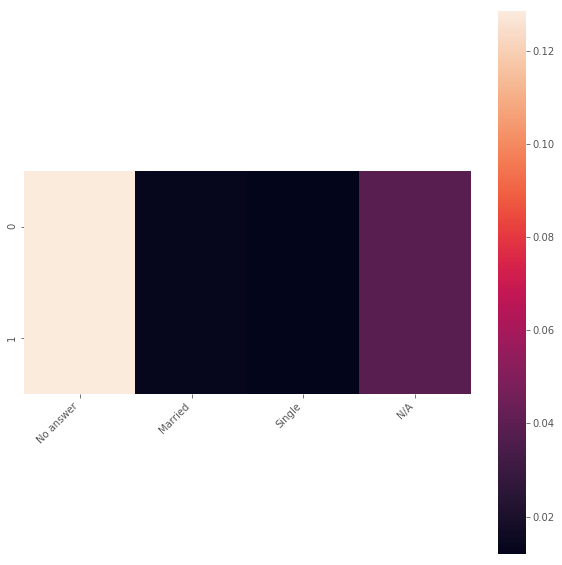

In [43]:
heatmap_matrix = np.abs(conjugacy_matrix_norm)
plt.figure(figsize=(10, 10))
ax = heatmap(heatmap_matrix, square=True)
ax.set_xticklabels(unique1, rotation=45, ha='right', minor=False)
plt.show()

На этой тепловой карте видно, что те, кто скрывает свой статус, скорее всего не вернут кредит, чем тем, кто его не скрывают.

### <font color="green">Выводы 04: __Семейное положение (MARRIAGE)__ </font>
- Зависимость между семейным положением и статусом возврата кредита есть
- Коэффициент корреляции V Краммера составляет 0.034 - слабая корреляция
- Основной вывод: если человек скрывает свое семейное положение, то он скорее всего не вернет кредит.

In [44]:
del mariage_def_on
del mariage_def_off

del unique1, counts1
del unique2, counts2
del y_pos1, y_pos2

del mariage_dic

del confusion_matrix
del ex_freq
del conjugacy_matrix
del conjugacy_matrix_norm

del confusion_df, ex_freq_df, conjugacy_df, heatmap_matrix, ax

### Часть 05.  __Возраст (AGE)__

Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 

1. О равенстве медианных значений возрастов людей 
2. О равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

In [45]:
age_def_on  = df[df.default == 1].AGE.values
age_def_off = df[df.default == 0].AGE.values

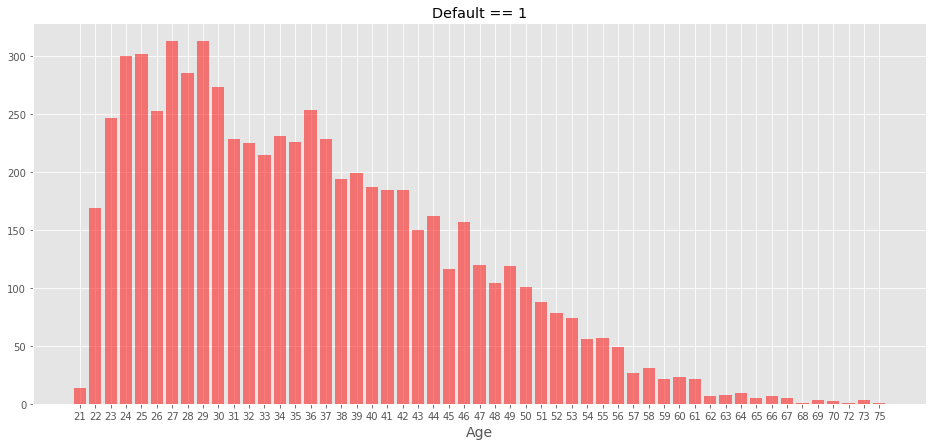

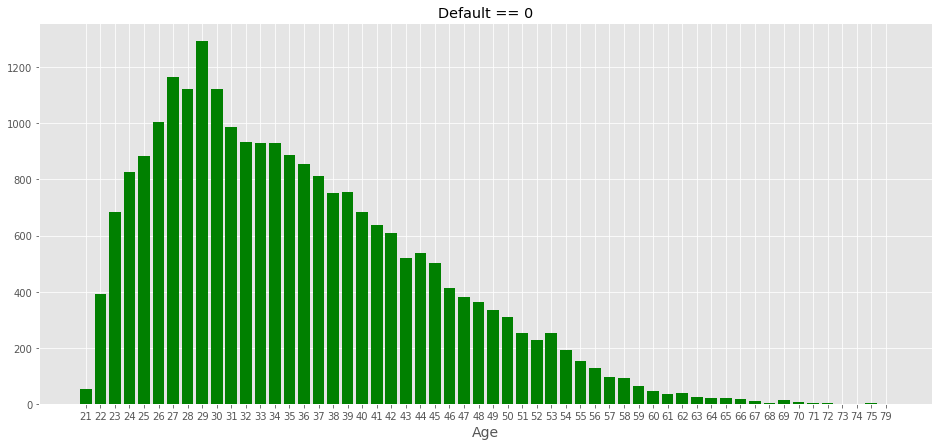

In [46]:
unique1, counts1 = np.unique(age_def_on,  return_counts=True)
unique2, counts2 = np.unique(age_def_off, return_counts=True)

y_pos1 = np.arange(len(unique1))
y_pos2 = np.arange(len(unique2))

plt.figure(figsize=(16, 7))
plt.bar(y_pos1, counts1, color = 'r', align='center', alpha=0.5)
plt.xlabel('Age', fontsize=14)
plt.title("Default == 1")
plt.xticks(y_pos1, unique1)
plt.show()

plt.figure(figsize=(16, 7))
plt.bar(y_pos2, counts2, color = 'g')
plt.xlabel('Age', fontsize=14)
plt.title("Default == 0")
plt.xticks(y_pos2, unique2)
plt.show()

Гистограммы довольно похожы друг на друга по форме. Возможно, мы имеем дело с одним законом распределения, но с разными параметрами

#### a) Интервальная оценка медиан:

Выборки являются независимыми. Для оценки медиан будем использовать метод Bootstrap.

In [47]:
%%time
#Интервальная оценка медиан
np.random.seed(0)

medians_def_on  = map(np.median, get_bootstrap_samples(age_def_on,  boostrap_size))
medians_def_off = map(np.median, get_bootstrap_samples(age_def_off, boostrap_size))

CPU times: user 12.8 s, sys: 779 ms, total: 13.6 s
Wall time: 13.6 s


##### Точечные оценки медиан и их интервальные оценки в каждой выборке

In [48]:
conf_on  = zconfint(medians_def_on)
conf_off = zconfint(medians_def_off)

print "95% confidence interval and median:"
print "Default == 1: {:10.2f} -> [{:4.2f}, {:4.2f}]".format(np.mean(medians_def_on), conf_on[0], conf_on[1])
print "Default == 0: {:10.2f} -> [{:4.2f}, {:4.2f}]".format(np.mean(medians_def_off), conf_off[0], conf_off[1])

95% confidence interval and median:
Default == 1:      34.10 -> [34.09, 34.10]
Default == 0:      34.00 -> [34.00, 34.00]


Видно, что интервалы пересекаются, следовательно, необходима дополнительная проверка, чтобы точно быть уверенными.

##### Доверительный интервал для разности медиан (независимые выборки)

In [49]:
print "Difference between medians: {:2.4f}".format(np.median(age_def_off) - np.median(age_def_on))
delta_medians = map(lambda x: x[0] - x[1], zip(medians_def_off, medians_def_on))
print "95% confidence interval for the difference between medians:" , stat_intervals(delta_medians, 0.05)
del delta_medians

Difference between medians: 0.0000
95% confidence interval for the difference between medians: [-1.  0.]


Доверительный интервал лежит целиком левее нуля, хотя правая граница очень близка к нулю.

#### б) Проверка статистическим критерием равенство средних:

In [50]:
#Для начала получим точечную оценку среднего, а также интервальную оценку для каждой выборки
conf_on = zconfint(age_def_on)
conf_off = zconfint(age_def_off)

print "95% confidence interval and mean:"
print "Default == 1: {:10.2f} -> [{:10.2f}, {:10.2f}]".format(age_def_on.mean(), conf_on[0], conf_on[1])
print "Default == 0: {:10.2f} -> [{:10.2f}, {:10.2f}]".format(age_def_off.mean(), conf_off[0], conf_off[1])

del conf_on
del conf_off

95% confidence interval and mean:
Default == 1:      35.73 -> [     35.49,      35.96]
Default == 0:      35.42 -> [     35.30,      35.53]


Интервальная оценка средних дает два пересекающихся интервала. Проверим равенство средних стат. критерием.

##### Проверим гипотезу о равенстве распределений с помощью перестановочного критерия:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

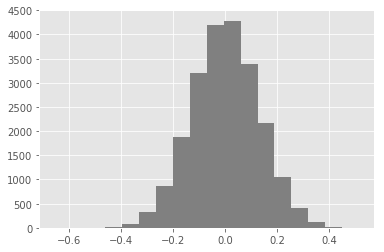

CPU times: user 1min 18s, sys: 4.09 s, total: 1min 22s
Wall time: 1min 41s


In [51]:
%%time
perm, t_stat = permutation_zero_dist_ind(age_def_off, age_def_on, max_combinations = permutations)

plt.hist(perm, bins=18, color='gray')
plt.show()

In [52]:
%%time
print "p-value: %f" % permutation_test(perm, t_stat)

p-value: 0.017591
CPU times: user 2.69 ms, sys: 9.77 ms, total: 12.5 ms
Wall time: 13.9 ms


Достигаемый уровень значимости значительно ниже $\alpha = 0.05$. Гипотеза $H_0$ отвергается.
Однако, посмотрим на результат вычислений:

In [53]:
print "Def=1 mean: {:2.4f}".format(np.mean(age_def_on))
print "Def=0 mean: {:2.4f}".format(np.mean(age_def_off))

Def=1 mean: 35.7257
Def=0 mean: 35.4173


Получается, что статистически средний возраст в двух выборках различен, и такой результат статистически значим, но на практике мы видим, что это различие не существенно.

### <font color="green">Выводы 05: __Возраст (AGE)__ </font>

__Проверка гипотезы о равенстве распределений:__

__1. Интервальная оценка равенства медианных значений возрастов клиентов.__
- Медианные значения не различаются.
- Точечная оценка разности медиан составляет 0 при дов. интервале (-1, 0)

__2. Применение непараметрического критерия проверки равенства средних значений возрастов клиентов.__
Проверяем гипотезу

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

- Вычисленный достигаемый уровень значимости $p_value = 0.016$ и $p \ll 0.05$. Следовательно, мы не можем принять гипотезу о равенстве средних.
- Чисто визуально, средние значения отличаются не сильно, потому, возможно, уровень $\alpha = 0.05$ сильно завышен
- С практической точки зрения такая разница в возрастах не имеет значения.

__3. Общий вывод.__
- Проверка на равенство распределений по основным моментам показала, что есть различия.
- С практической точки зрения различия не представляются существенными.

In [54]:
del age_def_on
del age_def_off

del unique1, counts1
del unique2, counts2
del y_pos1, y_pos2

del medians_def_on
del medians_def_off

del perm